In [541]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [542]:
# Core #
import json
import os
import re

# IO
import h5py

# Science And Plotting #
import matplotlib
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import holoviews as hv
import holoviews.util
hv.extension('matplotlib')

sns.set()

from scipy import optimize

# Analysis #
import arpes
import arpes.config
from arpes.models.spectrum import DLD_Spectrum_factory, load_SES
from arpes.models.view import View

# Jupyter #
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets

# Configure Jupyter #
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

<script src="https://code.jquery.com/ui/1.10.4/jquery-ui.min.js" type="text/javascript"></script>
<script type="text/javascript">function HoloViewsWidget(){
}

HoloViewsWidget.comms = {};
HoloViewsWidget.comm_state = {};

HoloViewsWidget.prototype.init_slider = function(init_val){
	if(this.load_json) {
		this.from_json()
	} else {
		this.update_cache();
	}
}

HoloViewsWidget.prototype.populate_cache = function(idx){
    this.cache[idx].html(this.frames[idx]);
    if (this.embed) {
        delete this.frames[idx];
    }
}

HoloViewsWidget.prototype.process_error = function(msg){

}

HoloViewsWidget.prototype.from_json = function() {
	var data_url = this.json_path + this.id + '.json';
	$.getJSON(data_url, $.proxy(function(json_data) {
		this.frames = json_data;
		this.update_cache();
		this.update(0);
	}, this));
}

HoloViewsWidget.prototype.dynamic_update = function(current){
	if (current === undefined) {
		return
	}
	if(this.dynamic) {
		current = JSON.stringify(current);
	}
	function callback(initialized, msg){
		/* This callback receives data from Python as a string
		   in order to parse it correctly quotes are sliced off*/
		if (msg.content.ename != undefined) {
			this.process_error(msg);
		}
		if (msg.msg_type != "execute_result") {
			console.log("Warning: HoloViews callback returned unexpected data for key: (", current, ") with the following content:", msg.content)
			this.time = undefined;
			this.wait = false;
			return
		}
		this.timed = (Date.now() - this.time) * 1.1;
		if (msg.msg_type == "execute_result") {
			if (msg.content.data['text/plain'].includes('Complete')) {
				this.wait = false;
				if (this.queue.length > 0) {
					this.time = Date.now();
					this.dynamic_update(this.queue[this.queue.length-1]);
					this.queue = [];
				}
				return
			}
		}
	}
	this.current = current;
	if ((window.Jupyter !== undefined) && (Jupyter.notebook.kernel != null)) {
		var kernel = Jupyter.notebook.kernel;
		callbacks = {iopub: {output: $.proxy(callback, this, this.initialized)}};
		var cmd = "holoviews.plotting.widgets.NdWidget.widgets['" + this.id + "'].update(" + current + ")";
		kernel.execute("import holoviews;" + cmd, callbacks, {silent : false});
	}
}

HoloViewsWidget.prototype.update_cache = function(force){
    var frame_len = Object.keys(this.frames).length;
    for (var i=0; i<frame_len; i++) {
        if(!this.load_json || this.dynamic)  {
            frame = Object.keys(this.frames)[i];
        } else {
            frame = i;
        }
        if(!(frame in this.cache) || force) {
			if ((frame in this.cache) && force) { this.cache[frame].remove() }
			this.cache[frame] = $('<div />').appendTo("#"+"_anim_img"+this.id).hide();
			var cache_id = "_anim_img"+this.id+"_"+frame;
			this.cache[frame].attr("id", cache_id);
			this.populate_cache(frame);
        }
    }
}

HoloViewsWidget.prototype.update = function(current){
    if(current in this.cache) {
        $.each(this.cache, function(index, value) {
            value.hide();
        });
        this.cache[current].show();
		this.wait = false;
    }
}

HoloViewsWidget.prototype.init_comms = function() {
	if ((window.Jupyter !== undefined) && (Jupyter.notebook.kernel !== undefined)) {
		var widget = this;
		comm_manager = Jupyter.notebook.kernel.comm_manager;
        comm_manager.register_target(this.id, function (comm) {
			comm.on_msg(function (msg) { widget.process_msg(msg) });
		});
	}
}

HoloViewsWidget.prototype.process_msg = function(msg) {
}

function SelectionWidget(frames, id, slider_ids, keyMap, dim_vals, notFound, load_json, mode, cached, json_path, dynamic){
    this.frames = frames;
    this.id = id;
    this.slider_ids = slider_ids;
    this.keyMap = keyMap
    this.current_frame = 0;
    this.current_vals = dim_vals;
    this.load_json = load_json;
    this.mode = mode;
    this.notFound = notFound;
    this.cached = cached;
    this.dynamic = dynamic;
    this.cache = {};
	this.json_path = json_path;
    this.init_slider(this.current_vals[0]);

In [561]:
full_metadata = None
with open(os.path.join(arpes.config.SOURCE_PATH, 'datasets/RhSn2/RhSn_June.json')) as metadata_file:
    full_metadata = json.load(metadata_file)

In [562]:
RhSnMap = load_SES(full_metadata[0])

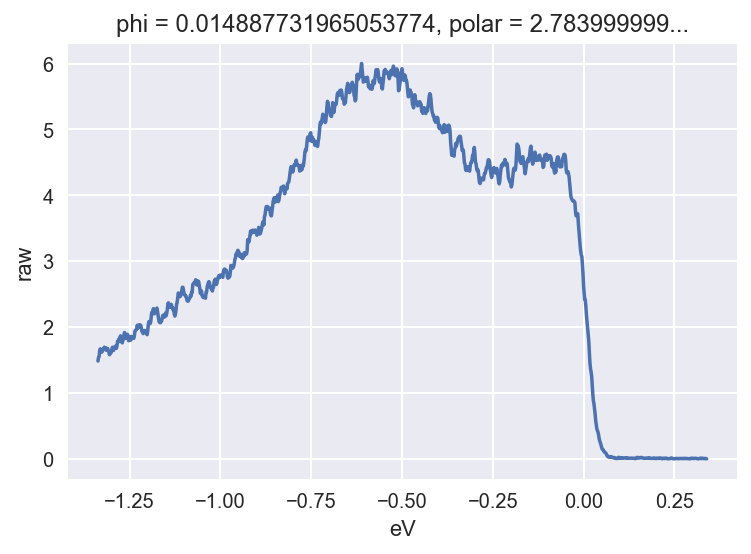

In [545]:
RhSnMap.raw.sel(polar=3, phi=0, method='nearest').plot()

In [12]:
cut = RhSnMap.raw.sel(polar=3, phi=0, method='nearest')

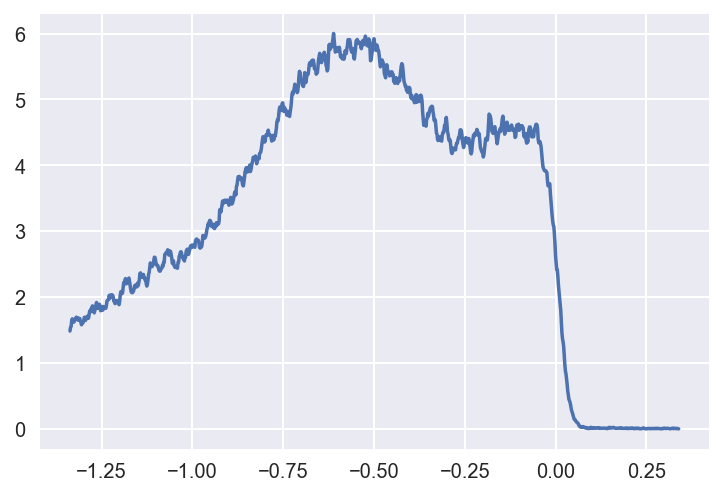

In [32]:
plt.plot(cut.coords['eV'].values, cut.values)

In [39]:
fit_result = gstepb_mod.fit(cut.values, x=cut.coords['eV'].values, center=0, width=0.03, erf_amp=5, 
                            lin_bkg=0, const_bkg=0)

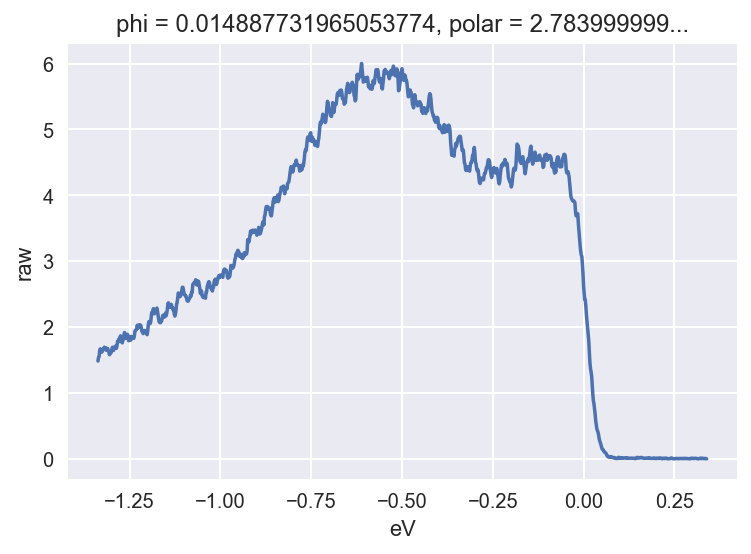

In [52]:
cut.plot()

In [550]:
from lmfit.model import Model
from arpes.fits import GStepBModel, QuadraticModel, broadcast_model

ds = RhSnMap.raw.sum('polar')
edge_fit = broadcast_model(GStepBModel, ds, 'phi')

In [558]:
from arpes.utilities import apply_dataarray
apply_dataarray(edge_fit, lambda x: x.values['center'].value)


AttributeError: 'numpy.ndarray' object has no attribute 'values'

In [559]:
edge_fit

<xarray.DataArray (phi: 777)>
array([<lmfit.model.ModelResult object at 0x147bf5400>,
       <lmfit.model.ModelResult object at 0x147be73c8>, ...,
       <lmfit.model.ModelResult object at 0x1eaafa390>], dtype=object)
Coordinates:
  * phi      (phi) float64 -20.25 -20.2 -20.15 -20.1 -20.06 -20.01 -19.96 ...

In [207]:
import collections
print(isinstance(np.identity(5), collections.Iterable))

True


In [560]:
apply_dataarray(edge_fit, lambda x: x.params['center'].stderr).plot()

AttributeError: 'numpy.ndarray' object has no attribute 'params'

In [200]:
from arpes.corrections import build_quadratic_fermi_edge_correction
corr = build_quadratic_fermi_edge_correction(RhSnMap.raw)

In [326]:
RhSnMap.raw.coords['eV']
deltac = RhSnMap.raw.coords['eV'].values[1] - RhSnMap.raw.coords['eV'].values[0] 

In [336]:
from arpes.corrections import apply_quadratic_fermi_edge_correction
corrected = apply_quadratic_fermi_edge_correction(RhSnMap.raw, corr)

0 1


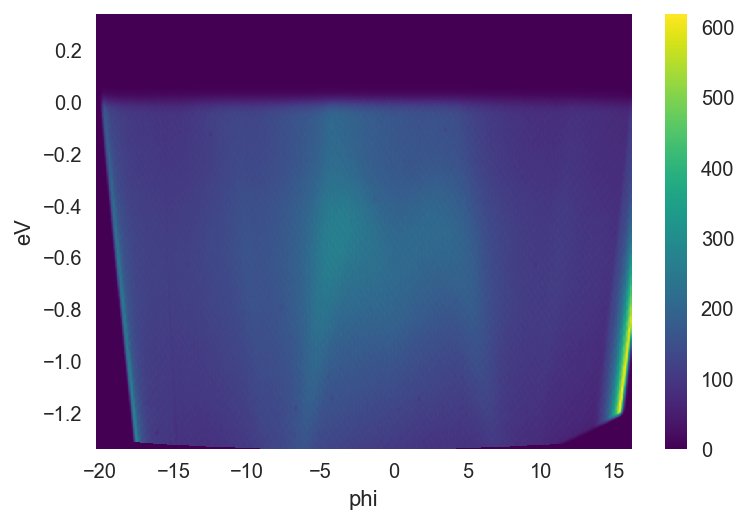

In [345]:
corrected.sum('polar').plot()

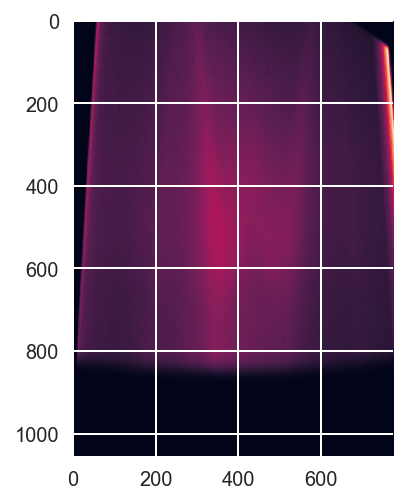

In [348]:
test_data = RhSnMap.raw.sum('polar')
plt.imshow(test_data)

In [358]:
import numpy.fft
ft = numpy.fft.rfftn(test_data)

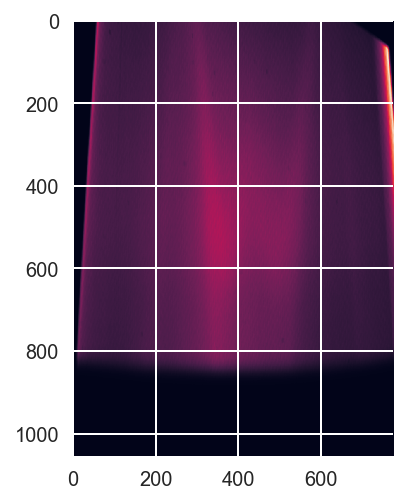

In [362]:
plt.imshow(numpy.fft.irfftn(ft))

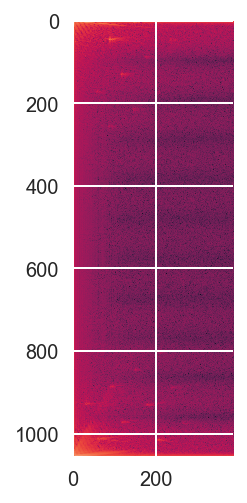

In [367]:
plt.imshow(np.log(numpy.absolute(ft)))

array([[  8.76129398e+07 +0.00000000e+00j,
         -1.61524086e+07 -2.01542420e+06j,
          3.92694840e+06 +8.32831080e+04j, ...,
         -7.63216032e+04 -4.79321947e+01j,
         -7.81122578e+04 +4.18802827e+02j,
         -7.70069753e+04 +1.06570009e+03j],
       [ -2.31018243e+07 -1.41028272e+07j,
          5.88074008e+06 +3.61933795e+05j,
         -1.02972574e+06 +1.50968559e+05j, ...,
          3.90261892e+04 +3.29492912e+04j,
          3.92539161e+04 +3.26915899e+04j,
          4.01568849e+04 +3.19925036e+04j],
       [ -4.34603015e+06 -1.22500465e+07j,
         -9.24335435e+05 +1.19963290e+06j,
         -2.71488395e+05 -8.39624658e+05j, ...,
          1.52376196e+04 -2.23700444e+04j,
          1.84790351e+04 -1.94056602e+04j,
          1.47048030e+04 -1.98468021e+04j],
       ..., 
       [  2.05071123e+06 +7.82753055e+06j,
         -1.70916367e+05 -2.04817017e+06j,
         -5.73567198e+05 -1.83956939e+05j, ...,
         -1.86479705e+04 +9.58264592e+03j,
         -1.746267

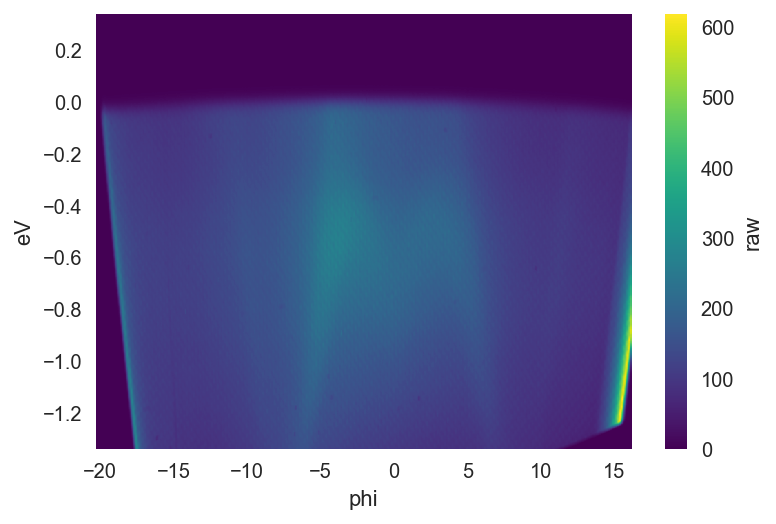

In [377]:
test_data = RhSnMap.raw.sum('polar')
test_data.plot()

In [379]:
from scipy.ndimage.filters import gaussian_filter1d
from scipy import signal


In [381]:
t = np.linspace(0, 1.0, 2001)
xlow = np.sin(2 * np.pi * 5 * t)
xhigh = np.sin(2 * np.pi * 250 * t)
x = xlow + xhigh

b, a = signal.butter(8, 0.125)

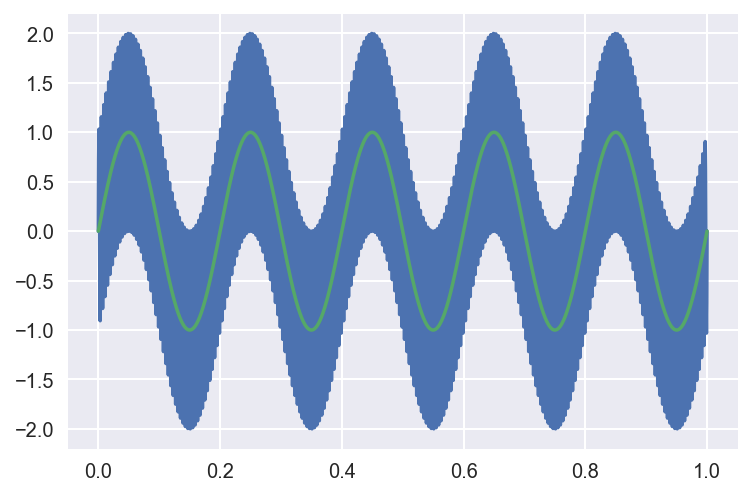

In [382]:
y = signal.filtfilt(b, a, x, padlen=150)
plt.plot(t, x)
plt.plot(t, y)

In [447]:
test_data = test_data[:,50:750]

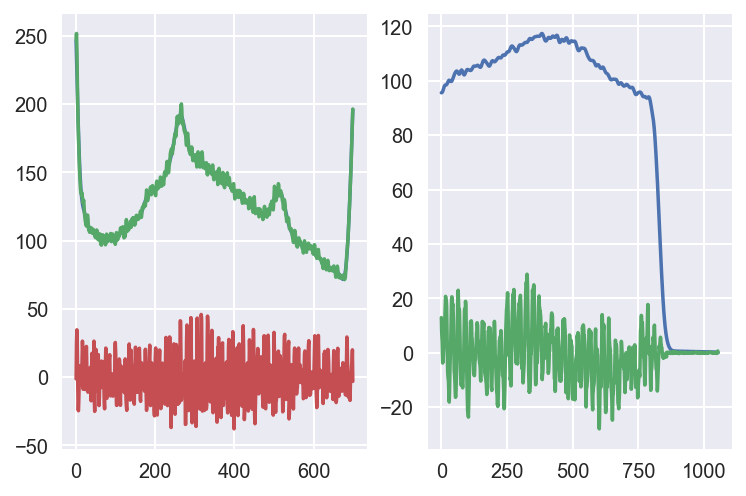

In [472]:
b, a = signal.butter(5, 1/7.1)
filtered = signal.filtfilt(b, a, test_data, axis=0, padlen=50)
c, d = signal.butter(5, 1/8)
filtered = signal.filtfilt(c, d, filtered, axis=1, padlen=150)
c, d = signal.butter(5, 1/10)
filtered = signal.filtfilt(c, d, filtered, axis=1, padlen=150)
f, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot((filtered)[150,:])
ax1.plot(test_data[150,:])
ax1.plot(5*(test_data - filtered)[300,:])
ax2.plot(filtered[:,50])
#ax2.plot(test_data[:,50])
ax2.plot(5*(test_data - filtered)[:,50])


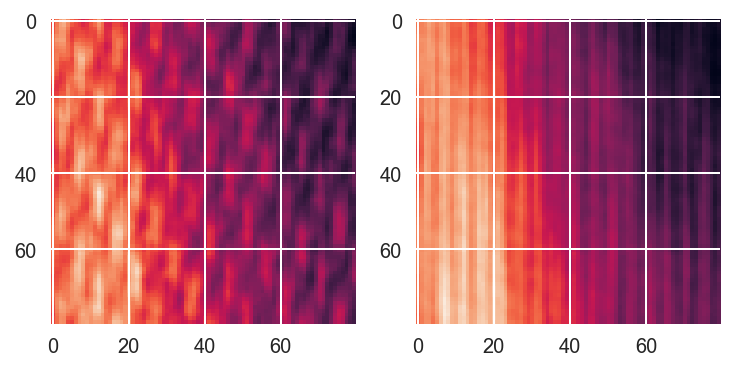

In [534]:
test_x, test_y = 300, 600

f, (ax1, ax2) = plt.subplots(1,2)
ax1.imshow(test_data[test_x:test_x + 80,test_y:test_y + 80])
ax2.imshow(filtered[test_x:test_x + 80,test_y:test_y + 80])

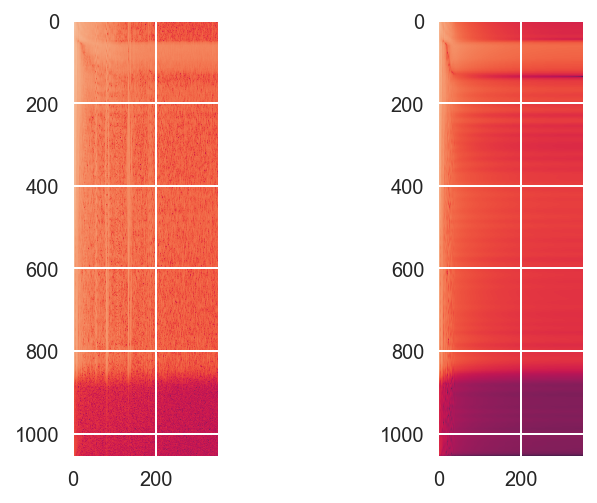

In [477]:
import scipy
f, (ax1, ax2) = plt.subplots(1,2)
ax1.imshow(np.log(np.absolute(np.fft.rfft(test_data))))
ax2.imshow(np.log(np.absolute(np.fft.rfft(filtered))))

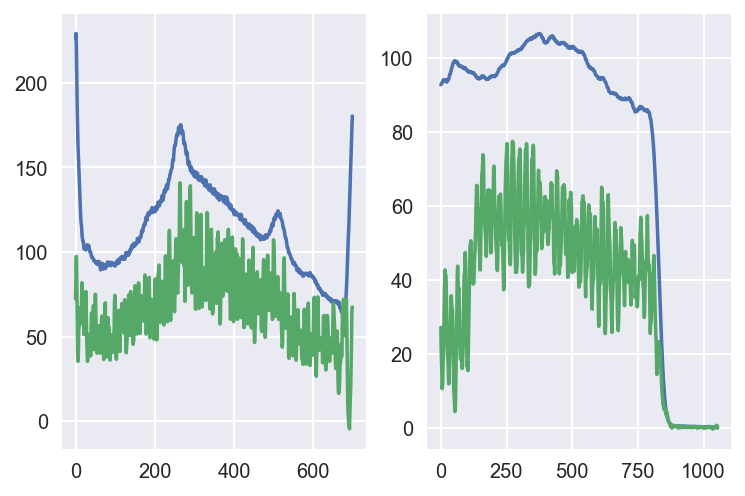

In [539]:
b, a = signal.ellip(2, 1/7.1, 2, 1/20.1)
c, d = signal.ellip(2, 1/7.1, 2, 1/20.1)
filtered = signal.filtfilt(b, a, test_data, axis=0)
filtered = signal.filtfilt(c, d, filtered, axis=1)
filtered = signal.filtfilt(b, a, filtered, axis=0)

f, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot((filtered)[150,:])
#ax1.plot(test_data[150,:])
ax1.plot(5*(test_data - filtered)[300,:])
ax2.plot(filtered[:,50])
#ax2.plot(test_data[:,50])
ax2.plot(5*(test_data - filtered)[:,50])


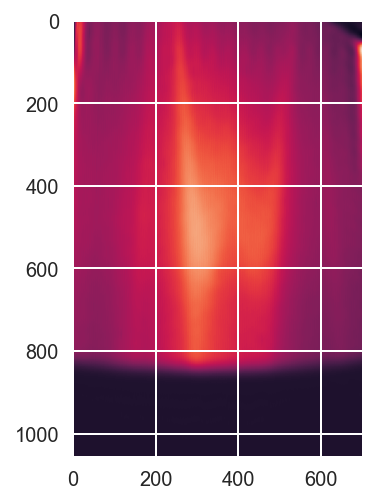

In [537]:
plt.imshow(filtered)